In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV , KFold
from sklearn.neighbors import KNeighborsRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [55]:
train_data=pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

In [56]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [57]:
train_data.drop(['Id','Utilities'],axis=1,inplace=True)

In [58]:
X=train_data.drop('SalePrice',axis=1)
y=train_data['SalePrice']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=74,shuffle=True)

<Axes: >

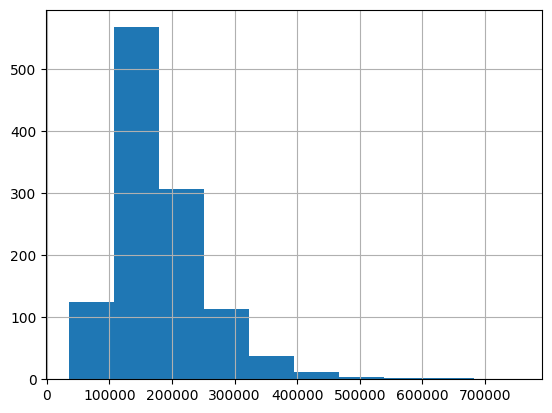

In [59]:
y_train.hist()

<Axes: >

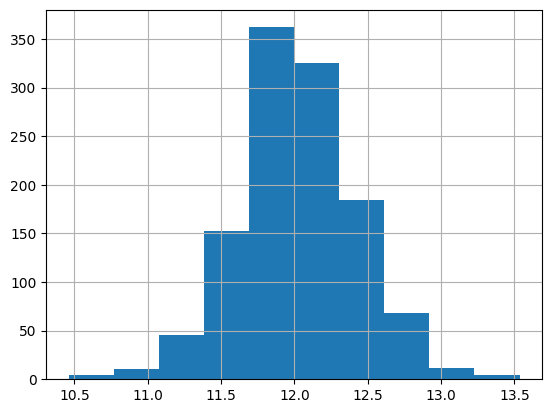

In [60]:
y_train=np.log1p(y_train)
y_train.hist()

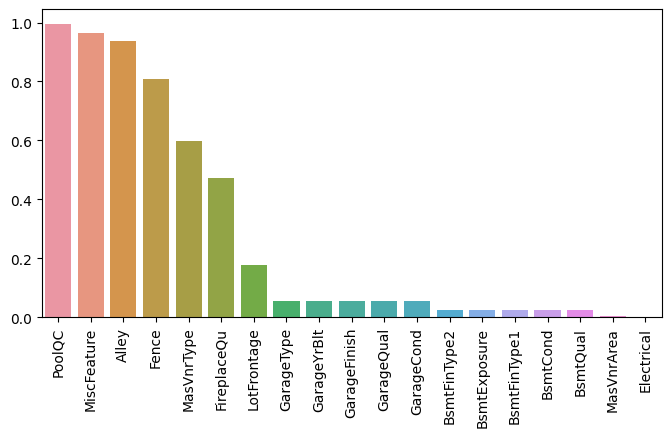

In [61]:
def draw_null_ratio(data):
    null_ratio=(data.apply(lambda x: x.isna().sum()/len(x)))
    null_ratio=null_ratio[null_ratio.values!=0].sort_values(ascending=False)
    f, ax = plt.subplots(figsize=(8, 4))
    plt.xticks(rotation=90)
    sns.barplot(x=null_ratio.index,y=null_ratio.values)

draw_null_ratio(train_data)


In [62]:
lotfrontage_mean=X_train.groupby(['Neighborhood'])['LotFrontage'].mean()
def fill_missing_values(data,lotfrontage_mean):
    def fill_lotfrontage(row):
        neighborhood = row['Neighborhood']
        if pd.isnull(row['LotFrontage']):
            return lotfrontage_mean[neighborhood]
        else:
            return row['LotFrontage']
    
    data['PoolQC']=data['PoolQC'].fillna('No')
    data['MiscFeature']=data['MiscFeature'].fillna('No')
    data['Alley']=data['Alley'].fillna('No')
    data['Fence']=data['Fence'].fillna('No')
    data['MasVnrType']=data['MasVnrType'].fillna('No')
    data['FireplaceQu']=data['FireplaceQu'].fillna('No')
    data['GarageType']=data['GarageType'].fillna('No')
    data['GarageYrBlt']=data['GarageYrBlt'].fillna(0)
    data['GarageFinish']=data['GarageFinish'].fillna('No')
    data['GarageQual']=data['GarageQual'].fillna('No')
    data['GarageCond']=data['GarageCond'].fillna('No')   
    data['BsmtFinType2']=data['BsmtFinType2'].fillna('No')
    data['BsmtExposure']=data['BsmtExposure'].fillna('No')
    data['BsmtFinType1']=data['BsmtFinType1'].fillna('No')
    data['BsmtCond']=data['BsmtCond'].fillna('No')
    data['BsmtQual']=data['BsmtQual'].fillna('No')
    data['Electrical']=data['Electrical'].fillna(data['Electrical'].mode()[0])
    data['LotFrontage']=data.apply(fill_lotfrontage,axis=1)
    data['MasVnrArea']=data['MasVnrArea'].fillna(0)    
    return data


In [63]:
# X_train=fill_missing_values(X_train)
# X_train.isna().sum()

In [64]:
pd.set_option('display.max_columns', None)
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1104,160,RM,24.0,2016,Pave,NaN,Reg,Lvl,Inside,Gtl,BrDale,Norm,Norm,TwnhsE,2Story,5,5,1970,1970,Gable,CompShg,HdBoard,HdBoard,BrkFace,304.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,630,630,GasA,TA,Y,SBrkr,630,672,0,1302,0,0,2,1,3,1,TA,6,Typ,0,NaN,Detchd,1970.0,Unf,2,440,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2007,WD,Normal
923,120,RL,50.0,8012,Pave,NaN,Reg,Lvl,Inside,Gtl,SawyerW,Norm,Norm,TwnhsE,1Story,6,5,1993,1994,Gable,CompShg,Plywood,Plywood,NaN,0.0,Gd,TA,PConc,Gd,TA,No,LwQ,165,GLQ,841,598,1604,GasA,Ex,Y,SBrkr,1617,0,0,1617,1,0,2,0,2,1,Gd,5,Typ,1,Fa,Attchd,1993.0,RFn,2,533,TA,TA,Y,0,69,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
75,180,RM,21.0,1596,Pave,NaN,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SLvl,4,5,1973,1973,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,462,Unf,0,0,462,GasA,TA,Y,SBrkr,526,462,0,988,1,0,1,0,2,1,TA,5,Typ,0,NaN,BuiltIn,1973.0,Unf,1,297,TA,TA,Y,120,101,0,0,0,0,NaN,GdWo,NaN,0,11,2009,WD,Normal
34,120,RL,60.0,7313,Pave,NaN,Reg,Lvl,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,9,5,2005,2005,Hip,CompShg,MetalSd,MetalSd,BrkFace,246.0,Ex,TA,PConc,Ex,TA,No,GLQ,1153,Unf,0,408,1561,GasA,Ex,Y,SBrkr,1561,0,0,1561,1,0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2005.0,Fin,2,556,TA,TA,Y,203,47,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
816,20,RL,NaN,11425,Pave,NaN,IR1,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1954,1954,Gable,CompShg,BrkFace,BrkFace,NaN,0.0,TA,TA,CBlock,TA,TA,No,BLQ,486,Unf,0,522,1008,GasA,Gd,Y,SBrkr,1008,0,0,1008,0,0,1,0,2,1,TA,4,Typ,1,Gd,Attchd,1954.0,RFn,1,275,TA,TA,Y,0,0,120,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal


In [65]:
# convert column categorical but it was int type
def numeical_to_categorical(data):
    numerical_column=['MSSubClass','YrSold','MoSold']
    data[numerical_column]=data[numerical_column].astype(str)
    return data

# X_train=numeical_to_categorical(X_train)


In [66]:
def encoding_order_features(data):

    cols=['FireplaceQu','BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
          'ExterQual', 'ExterCond','HeatingQC', 'PoolQC']
    for col in cols:
        encoder=LabelEncoder()
        encoder.fit(['No','Po','Fa','TA','Gd','Ex'])
        data[col]=encoder.transform(data[col])
    
    for col in ['MSSubClass', 'OverallCond','OverallQual','YrSold', 'MoSold']:
        encoder=LabelEncoder()
        data[col]=encoder.fit_transform(data[col])
        
    return data

# X_train=encoding_order_features(X_train)
# X_train

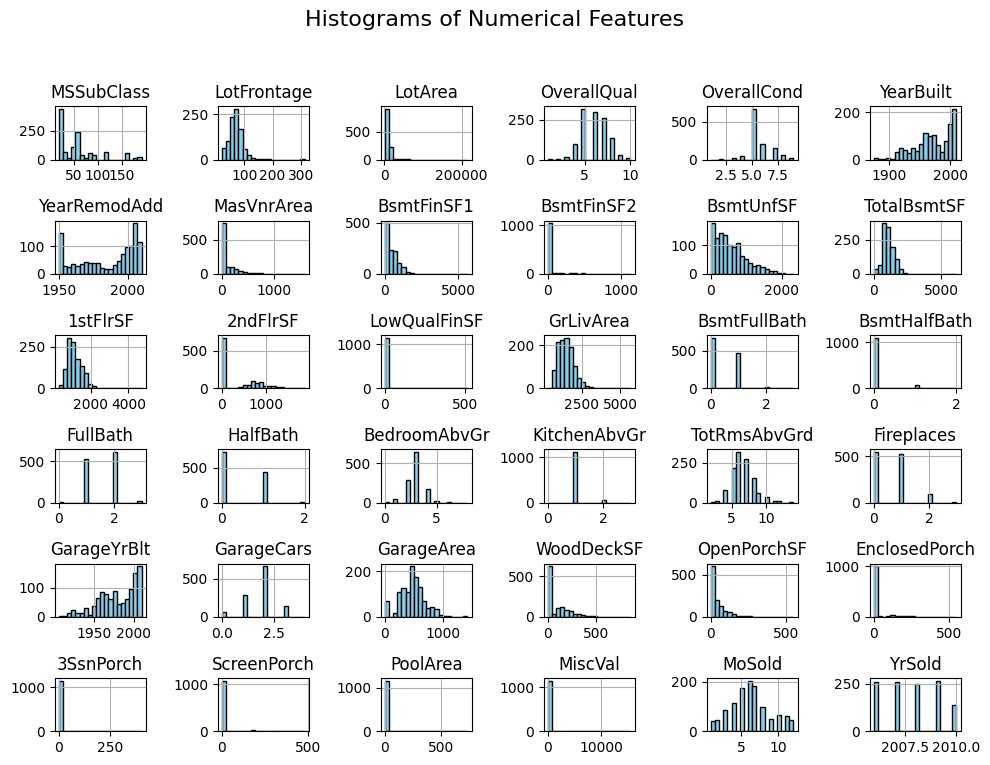

In [67]:
X_train.hist(figsize=(10, 8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [68]:
skewness=X_train.select_dtypes(exclude='object').skew()
cols_for_fit=skewness[abs(skewness) > 0.5]
def make_data_normal(data,cols_for_fit):
    cols=[col for col in cols_for_fit.index]
    for col in cols:
        lam=.25
        data[col]= boxcox1p(data[col], lam)
    return data
# cols_for_fit
# X_train=make_data_normal(X_train)

In [69]:
# X_train.select_dtypes(exclude='object').skew()

In [70]:
categorical_columns=X_train.select_dtypes(include='object').columns
combined_data = pd.concat([X_train, X_test])
# X_train=pd.get_dummies(X_train,columns=categorical_columns,prefix=categorical_columns,drop_first=True,dtype=int)
# X_train

In [71]:
preprocessing_pipline=Pipeline([
    ('fill_missing_values',FunctionTransformer(fill_missing_values,validate=False,kw_args={'lotfrontage_mean':lotfrontage_mean})),
    ('numeical_to_categorical',FunctionTransformer(numeical_to_categorical,validate=False)),
    ('encoding_order_features',FunctionTransformer(encoding_order_features,validate=False)),
    ('make_data_normal',FunctionTransformer(make_data_normal,validate=False,kw_args={'cols_for_fit':cols_for_fit})),
    ('get_dummies',FunctionTransformer(pd.get_dummies,validate=False,kw_args={'columns':categorical_columns,'prefix':categorical_columns,'drop_first':True,'dtype':int})),
])

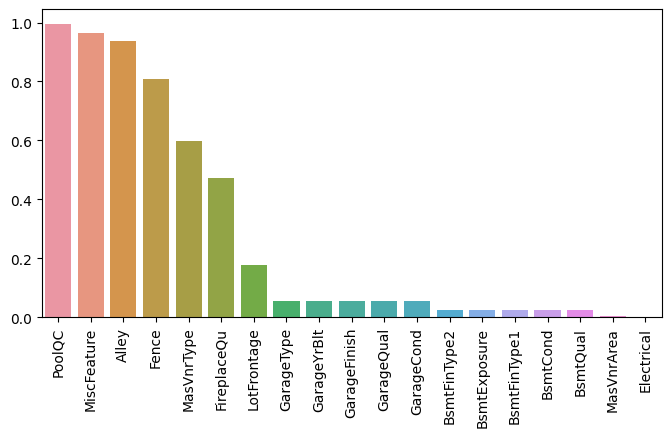

In [72]:
draw_null_ratio(train_data)

In [73]:
X_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
532,20,RL,60.0,7200,Pave,NaN,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1955,2007,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Ex,Y,SBrkr,827,0,0,827,0,0,1,0,2,1,TA,5,Mod,1,Po,Detchd,1967.0,Unf,1,392,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
403,60,RL,93.0,12090,Pave,NaN,Reg,Lvl,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,1998,1998,Hip,CompShg,VinylSd,VinylSd,BrkFace,650.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1141,1141,GasA,Gd,Y,SBrkr,1165,1098,0,2263,0,0,2,1,4,1,Gd,10,Typ,1,TA,BuiltIn,1998.0,Fin,2,420,TA,TA,Y,144,123,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Abnorml
751,60,RL,NaN,7750,Pave,NaN,Reg,Lvl,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,660,660,GasA,Ex,Y,SBrkr,660,660,0,1320,0,0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,2003.0,Fin,2,400,TA,TA,Y,0,48,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1136,50,RL,80.0,9600,Pave,NaN,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1.5Fin,6,5,1950,1950,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,BLQ,280,Unf,0,752,1032,GasA,TA,Y,FuseA,1032,220,0,1252,0,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1950.0,Unf,1,288,TA,TA,Y,0,0,96,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
1411,50,RL,80.0,9600,Pave,NaN,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1.5Fin,6,8,1950,2005,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,Gd,CBlock,TA,TA,No,BLQ,120,Unf,0,736,856,GasA,Ex,Y,SBrkr,1112,556,0,1668,0,0,1,1,3,1,TA,6,Min2,0,NaN,Attchd,1950.0,Unf,1,271,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,9,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,20,RL,88.0,12803,Pave,NaN,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,99.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,922,Unf,0,572,1494,GasA,Ex,Y,SBrkr,1494,0,0,1494,1,0,2,0,3,1,Gd,6,Typ,1,TA,Attchd,2002.0,RFn,2,530,TA,TA,Y,192,36,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
517,60,RL,79.0,10208,Pave,NaN,IR1,Lvl,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,921.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1264,1264,GasA,Ex,Y,SBrkr,1277,1067,0,2344,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,1996.0,RFn,3,889,TA,TA,Y,220,0,0,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
307,50,RM,NaN,7920,Pave,Grvl,IR1,Lvl,Inside,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,6,7,1920,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Fa,CBlock,TA,TA,No,Unf,0,Unf,0,319,319,GasA,TA,Y,FuseA,1035,371,0,1406,0,0,1,0,3,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,144,0,0,0,0,NaN,MnPrv,NaN,0,3,2008,WD,Normal
1233,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1959,1959,Hip,CompShg,Plywood,Plywood,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,Rec,1000,Unf,0,188,1188,GasA,Fa,Y,SBrkr,1188,0,0,1188,1,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1959.0,RFn,2,531,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,5,2010,COD,Abnorml


In [74]:
combined_data_transformed=preprocessing_pipline.transform(combined_data)
X_train_transformed = combined_data_transformed.iloc[:len(X_train)]
X_test_transformed = combined_data_transformed.iloc[len(X_train):]

In [75]:
X_train_transformed.shape

(1168, 257)

In [76]:
X_test_transformed.shape

(292, 257)

In [77]:
model = LinearRegression()


In [78]:
# model.fit(X_train_transformed,y_train)
# y_pred = model.predict(X_test_transformed)
# y_pred=np.expm1(y_pred)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')
# print(f'r2_score: {r2_score(y_test,y_pred)}')

In [79]:
param_grid = {'fit_intercept': [True, False]  }


grid_search = GridSearchCV(model, param_grid, cv=5,scoring='r2')


grid_search.fit(X_train_transformed, y_train)



GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]}, scoring='r2')

In [80]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model=grid_search.best_estimator_

y_pred=np.expm1(best_model.predict(X_test_transformed))

print("Best Parameters:", best_params)
print("Best Score:", best_score)

mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'r2_score: {r2_score(y_test,y_pred)}')

Best Parameters: {'fit_intercept': True}
Best Score: 0.8011505020710029
Mean Squared Error: 1017052763.0316858
r2_score: 0.8679718286807079


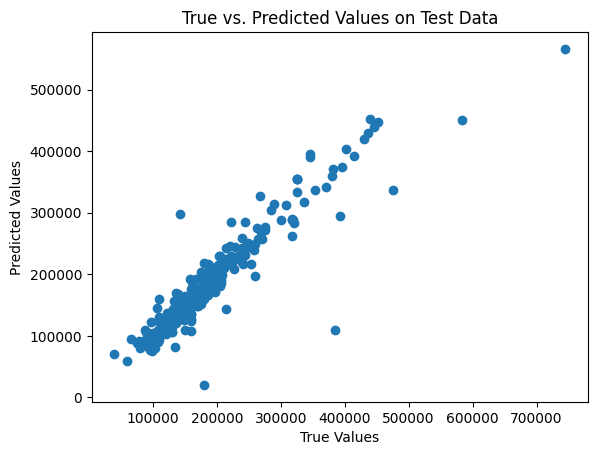

In [81]:
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values on Test Data")
plt.show()

In [82]:
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
      'metric': ['minkowski', 'manhattan', 'euclidean']
             }


grid_search_knn = GridSearchCV(knn, param_grid, cv=5,scoring='r2')


grid_search_knn.fit(X_train_transformed, y_train)

grid_search_knn.cv_results_

{'mean_fit_time': array([0.01685867, 0.01567621, 0.01509204, 0.01557412, 0.01539159,
        0.01544881, 0.01582417, 0.01538119, 0.01533709, 0.01558132,
        0.01557622, 0.0156642 , 0.01504636, 0.01524997, 0.01561084,
        0.01552973, 0.01521802, 0.01517348]),
 'std_fit_time': array([0.00154034, 0.00074512, 0.00018507, 0.00017731, 0.00022533,
        0.00017833, 0.00049739, 0.00020963, 0.00016075, 0.00047936,
        0.00026845, 0.00042452, 0.00022879, 0.00031991, 0.00029637,
        0.00038461, 0.00017281, 0.0002922 ]),
 'mean_score_time': array([0.01208863, 0.01144834, 0.01135764, 0.01179819, 0.01158042,
        0.01175952, 0.04416656, 0.04417892, 0.04414253, 0.04461503,
        0.04414835, 0.0446919 , 0.01109743, 0.01152124, 0.01160936,
        0.01156616, 0.01157255, 0.01171198]),
 'std_score_time': array([1.71198608e-03, 8.01794840e-05, 1.29635932e-04, 2.38687192e-04,
        1.07235938e-04, 1.31656458e-04, 2.70782593e-04, 1.46924772e-04,
        2.44434485e-04, 1.19369399e-

In [83]:
grid_search_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [84]:
best_model_knn=grid_search_knn.best_estimator_
y_pred_knn=np.expm1(best_model_knn.predict(X_test_transformed))
print(r2_score(y_test,y_pred_knn))

0.7024886107811074


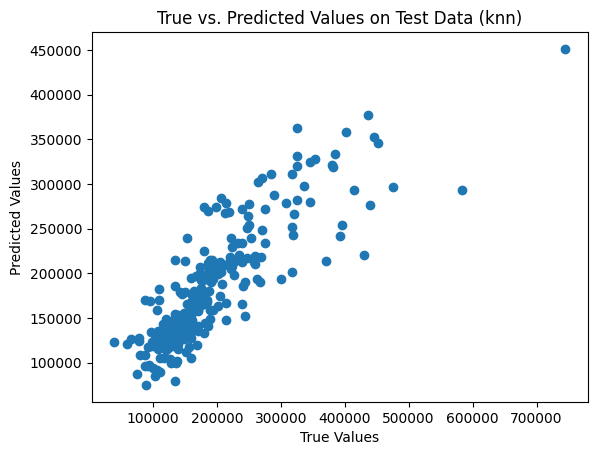

In [85]:
plt.scatter(y_test, y_pred_knn)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values on Test Data (knn)")
plt.show()

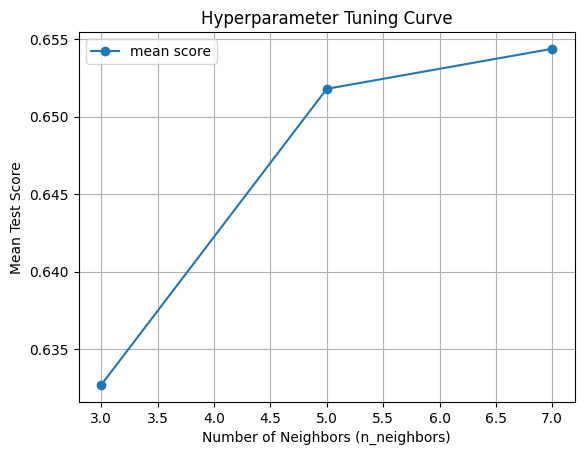

In [86]:
results = grid_search_knn.cv_results_
param_values = pd.to_numeric(results['param_n_neighbors'], errors='coerce') 
mean_test_scores = pd.to_numeric(results['mean_test_score'], errors='coerce')  
df = pd.DataFrame({'n_neighbors': param_values, 'mean score': mean_test_scores})
df=df.groupby('n_neighbors').mean()

df.plot(marker='o')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Mean Test Score')
plt.title('Hyperparameter Tuning Curve')
plt.grid(True)
plt.show()

In [87]:
pd.DataFrame({'n_neighbors':param_values,'mean score':mean_test_scores})

,n_neighbors,mean score
0,3,0.595377
1,3,0.602748
2,5,0.620132
3,5,0.630348
4,7,0.623947
5,7,0.636497
6,3,0.697399
7,3,0.702550
8,5,0.700585
9,5,0.709158
